In [ ]:
# default_exp nbeats.model_multi

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats model multi

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.layers import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *
from fastseq.nbeats.model import *

In [ ]:
# export
# TODO
def make_base_rnn(u_in, u_o, layers):
    return nn.LSTM(u_in, u_o, layers, batch_first=True)

In [ ]:
# export
class DependentModel(object):
    """Returns the result of polynominal function on the dependent variable.
    
    r = theta[0] + sum((theta[i]*t)^i)
    """
    def __init__(self, norm=True):
        self.norm = norm
        
    def __call__(self, thetas, t, *args):
        p = thetas.size()[-1]
        assert p < 5, f"thetas_dim is too big. p = {p}"
        s = [(thetas[:,0][:,None] * torch.ones_like(t))[:,:,None]]
        for i in range(1, p):
            o = (t*thetas[:,i][:,None])**(i)
            s.append(o[:,:,None])       
        return torch.cat(s,-1).sum(-1)

In [ ]:
# export
class DependentBlock(Block):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, norm = True, rnn_base = False,
            bn_final=False, ps:L=None, share_thetas=True, y_range=[-.5,.5], att=True, scale_exp = 1.2, stand_alone=False, base = None, **kwargs
    ):
        
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas,att,stand_alone,base,rnn_base" )
        self.scale = 1*scale_exp**-(torch.arange(float(self.thetas_dim))).to(self.device)
#         self.scale[2] = .1
        print(self.scale)
        if rnn_base:
            self.seq_base = make_base_rnn(2, 2, 3)
        super().__init__(DependentModel(norm))
        self.base =  make_base(self.lookback*2+ (2 if rnn_base else 0), self.layers, self.use_bn, self.ps)
        self.to(device)
        

    def forward(self,x, xts, *args):
        if not self.stand_alone:
            x, xts = x[:,None,:], xts[:,None,:]
        x = torch.cat([x, xts[:,:,:self.lookback]],1)
        if self.rnn_base:
            out,(h,c) = self.seq_base(x.transpose(1,2))
        x = x.reshape([x.shape[0],self.lookback*2])
        if self.rnn_base:
            x = torch.cat([x, h[-1]],-1)
        dct = super().forward(x, xts[:,0,:self.lookback], xts[:,0,self.lookback:])
        if self.stand_alone:
            return torch.cat([dct['b'][:,None,:], dct['f'][:,None,:]],dim=-1)
        else:
            return dct

In [ ]:
# hide
device = default_device()
mdl = DependentBlock([256], thetas_dim=4, device=device, lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(device),torch.randn(64,110).to(device))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['attention'].shape, (64,4))

mdl = SeasonalityBlock([256], thetas_dim=4, device=device, lookback=100, horizon=10, stand_alone=True)
bf = mdl(torch.randn(64,1,100).to(device))
test_eq(bf.shape, (64,1,110))

tensor([1.0000, 0.8333, 0.6944, 0.5787], device='cuda:0')


Train:50; Valid: 300; Test 50
tensor([1.0000, 0.8333, 0.6944, 0.5787], device='cuda:0')


epoch,train_loss,valid_loss,time
0,4.765599,2.741851,00:01
1,3.813070,2.017403,00:01
2,3.326098,1.714862,00:01
3,3.041374,1.392408,00:01
4,2.838420,1.223360,00:01
5,2.676021,1.171144,00:01
6,2.550235,1.103973,00:01
7,2.447692,1.095672,00:01
8,2.364252,1.096500,00:01
9,2.297712,1.080865,00:01


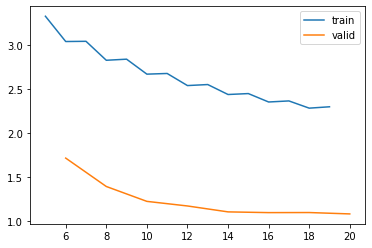

In [ ]:
from fastseq.data.core_pd import *
horizon, lookback = 10, 15
df = dummy_generator_multi_easy(50, nrows=50, rang=[-2,0], noise=0)
data = DfDataLoaders.from_df(df, 'x', horizon = horizon, lookback=lookback, step=1,
                             valid_pct=.5, bs = 32)
                                
mdl = DependentBlock([256, 128], thetas_dim=4, device = data.train.device, horizon=horizon, lookback=lookback,
                     stand_alone=True, rnn_base = False, rang=[-.5,.5])
learn = Learner(data, mdl, loss_func=F.mse_loss, opt_func= Adam,)                  

learn.fit(10, .01)
learn.recorder.plot_loss()     

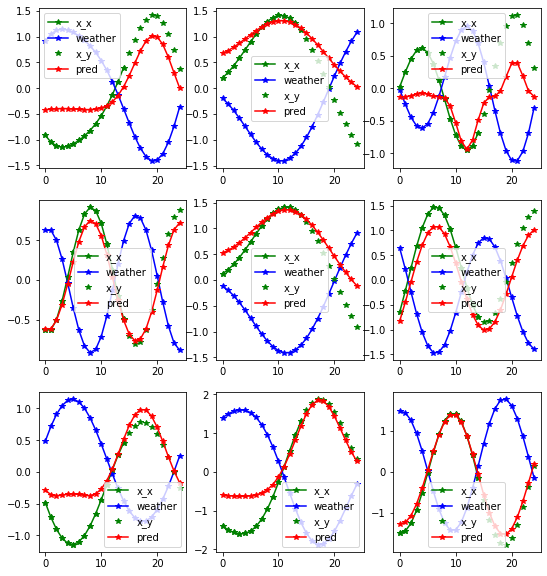

In [ ]:
learn.show_results(1,max_n = 9)

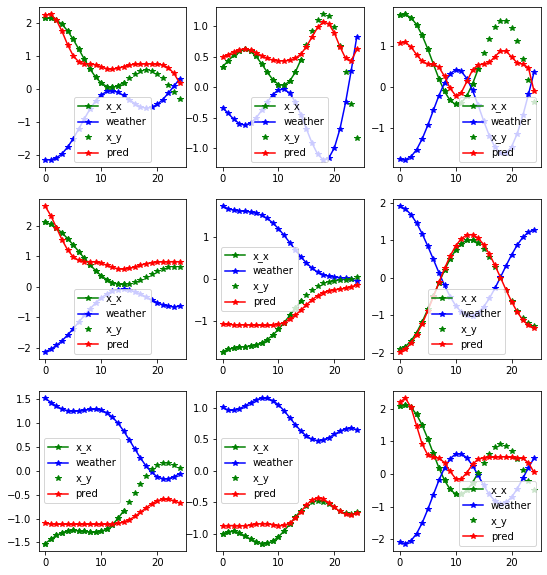

In [ ]:
learn.show_results(0,max_n = 9)

In [ ]:
git_add('050_nbeats.models_multi.ipynb')

Converted 050_nbeats.models_multi.ipynb.


['/home/tako/dev/fastseq/fastseq/nbeats/model_multi.py',
 '/home/tako/dev/fastseq/nbs/050_nbeats.models_multi.ipynb']

In [ ]:
show_doc(DependentModel,default_cls_level=3)

<h3 id="DependentModel" class="doc_header"><code>class</code> <code>DependentModel</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>DependentModel</code>(**`norm`**=*`True`*)

Returns the result of polynominal function on the dependent variable.

r = theta[0] + sum((theta[i]*t)^i)

(-2, 2)

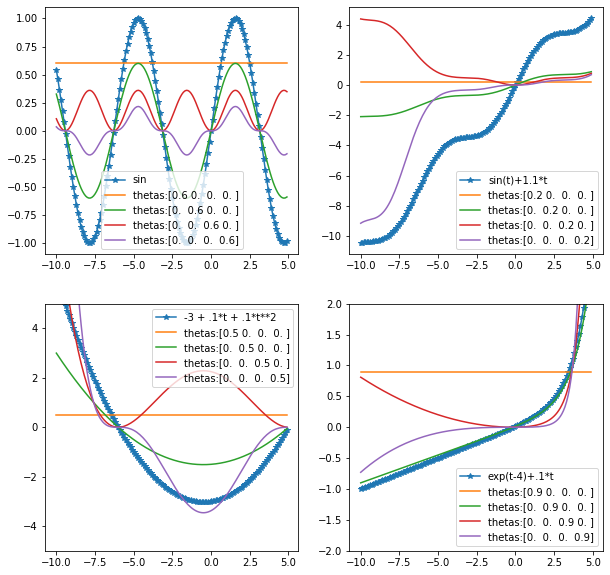

In [ ]:
from fastai2.vision.data import *
axs = get_grid(4, figsize=(10,10))
num_thetas = 4
start, end = -10, 5.


t = torch.arange(start, end, .1, device='cuda:0')[None,:]
t = torch.cat([t]*32,0)

def theta_influence(dep, ax, theta_lev=.5, label = ''):
    theta = (torch.zeros(num_thetas, device='cuda:0'))[None,:]
    theta = torch.cat([theta]*32,0)
    for i in range(num_thetas ):
        theta[i,i] = theta_lev
    fnc = DependentModel()
    ax.plot(t.cpu()[0], dep.cpu()[0], marker='*', label = label)
    r = fnc(theta, dep).cpu()
    for i in range(num_thetas):
        ax.plot(t.cpu()[0], r[i], label = f"thetas:{theta[i].data.cpu().numpy()}")
    ax.legend()
    
dep = torch.sin(t)
theta_influence(dep, axs[0], theta_lev=.6, label = 'sin')
dep = torch.sin(t)+1.1*t
theta_influence(dep, axs[1], theta_lev=.2, label = 'sin(t)+1.1*t')
dep = -3+.1*t+.1*t**2
theta_influence(dep, axs[2], theta_lev=.5, label = '-3 + .1*t + .1*t**2')
axs[2].set_ylim([-5,5])
dep = torch.exp(t-4)+.1*t
theta_influence(dep, axs[3], theta_lev=.9, label = 'exp(t-4)+.1*t')
axs[3].set_ylim([-2,2])

In [ ]:
# export
# not pritty but still works better
def _select_block(o):
    if isinstance(o,int):
        if o == 0:
            return SeasonalityBlock
        elif o == 1:
            return TrendBlock
        elif o == 2:
            return BaisBlock
        elif o == 3:
            return BaisBlock
        else:
            return GenericBlock
    else:
        if o == 'seasonality':
            return SeasonalityBlock
        elif o == 'trend':
            return TrendBlock
        elif o =='bias':
            return BiasBlock
        elif o =='dependent':
            return DependentBlock
        else:
            return GenericBlock

_default_thetas={'seasonality':6,'trend':4,'bais':2, 'dependent':4}

In [ ]:
# export
class NBeatsMNet(Module):
    def __init__(
        self,
        device,
        stack_types=('trend', 'seasonality', 'dependent'),
        nb_blocks_per_stack=3,
        horizon=5,
        lookback=10,
        thetas_dim=None,
        share_weights_in_layers=True,
        layers= [1024,512],
        **kwargs,
    ):
        thetas_dim = ifnone(thetas_dim,[_default_thetas[o] for o in L(stack_types)])
        stack_types= L(stack_types)
        store_attr(self,'device,horizon,lookback,layers,nb_blocks_per_stack,share_weights_in_layers,stack_types,thetas_dim,device,norm,kwargs')
        self.stacks = []
        self._str = "| N-Beats\n"

        self.bn = BatchNorm(lookback, ndim=2)
        stacks = OrderedDict()
        self.base = None
        if self.share_weights_in_layers:
            self.base = make_base(self.lookback, self.layers, True, None)
        for stack_id in range(len(self.stack_types)):
            stacks[str(self.stack_types[stack_id]) + str(stack_id)] = self.create_stack(stack_id)
        self.stacks = nn.Sequential(stacks)

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        self._str += f"| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_layers})\n"

        blocks = []
        for thetas_dim in range(3,self.thetas_dim[stack_id]+1):
            block_init = _select_block(stack_type)
            block = block_init(
                layers = self.layers,
                thetas_dim = thetas_dim,
                device = self.device,
                lookback = self.lookback,
                horizon = self.horizon,
                base = self.base,
                **self.kwargs
                )
            self._str += f"     | -- {block}\n"
            blocks.append(block)

        return nn.Sequential(*blocks)

    def iter_blocks(self):
        for stack_id, names in enumerate(self.stacks.named_children()):
            name = names[0]
            for block_id in range(len(self.stacks[stack_id])):
                yield name, stack_id, block_id, self.stacks[stack_id][block_id]

    def forward(self, x, xts, cat, con):
        self.dct = None
        
        backcast_res = x.view([-1,x.shape[-1]])
        backcast = torch.zeros(
            size=(backcast_res.size()[0], self.lookback,)
        )
        forecast = torch.zeros(
            size=(backcast.size()[0], self.horizon,)
        )  # maybe batch size here.

        dct = defaultdict(dict)
        for stack_id, names in enumerate(self.stacks.named_children()):
            name = names[0]
            for block_id in range(len(self.stacks[stack_id])):
                _dct = self.stacks[stack_id][block_id](backcast_res)
                backcast_res = backcast_res.to(self.device) - _dct['b']

                backcast = backcast.to(self.device) + _dct['b']
                forecast = forecast.to(self.device) + _dct['f']
                _dct['_full'] = torch.cat([_dct['b'] , _dct['f']], dim=-1)
                dct[name+'_'+str(block_id)] = _dct

        dct['f'] = forecast[:,None,:]
        dct['b'] = backcast[:,None,:]
        self.dct = dct
        res = torch.cat([backcast[:,None,:], forecast[:,None,:]], dim=-1)
        return res

    def __setattr__(self, key, value):
        if key in ['lookback','horizon']:
            if hasattr(self,'stacks'):
                for name, stack_id, block_id, stack in self.iter_blocks():
                    setattr(stack, key, value)
        super().__setattr__(key, value)

In [ ]:
show_doc(select_block, name='select_block')

<h4 id="select_block" class="doc_header"><code>select_block</code><a href="https://github.com/takotab/fastseq/tree/master/fastseq/nbeats/model.py#L186" class="source_link" style="float:right">[source]</a></h4>

> <code>select_block</code>(**`o`**)



In [ ]:
# hide
# basic training
from fastseq.compare import *
horizon, lookback = 7,25
items = dummy_data_generator(50, 7, nrows=10, norm=True)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=2, after_batch = NormalizeTS())
                                
mdl = NBeatsNet(device = data.train.device, stack_types=('trend','seasonality'), horizon=horizon, lookback=lookback, season=lookback+horizon)
learn = Learner(data, NBeatsNet(device = data.train.device, stack_types=('trend','seasonality'), horizon=horizon, lookback=lookback),
                            loss_func=F.mse_loss, opt_func= Adam, )             
learn.fit(2,2e-2)

(1, 57)
Train:10; Valid: 60; Test 10


epoch,train_loss,valid_loss,time
0,1.317809,2.667894,00:00
1,1.891930,2.207786,00:00


In [ ]:
# hide
# __setattr__ for lookback, horizon
mdl = NBeatsNet(torch.device('cpu'), stack_types=('trend','seasonality'), season=lookback+horizon )
_ = mdl(torch.randn(64,1,10))
mdl.horizon = 1

test_eq(mdl.horizon, 1)
for name, stack_id, block_id, stack in mdl.iter_blocks():
    test_eq(stack.horizon, 1)
    
mdl.lookback = 11

test_eq(mdl.lookback, 11)
for name, stack_id, block_id, stack in mdl.iter_blocks():
    test_eq(stack.lookback, 11)

In [ ]:
# hide
# self.norm
horizon, lookback = 5,10
items = dummy_data_generator(50, 7, nrows=10, norm=True)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=2)

mdl = NBeatsNet(data.train.device, stack_types=('trend','seasonality'), share_weights_in_layers=True, norm = True)
i = torch.randn(128,1,10)*10+15
out = mdl(i.to(data.train.device))
test_eq(out.shape, (128,1,horizon+lookback))
# test_close(mdl.m.mean(), i.mean(-1,keepdim=True).mean())
# test_close(mdl.s.mean(), i.std(-1,keepdim=True).mean())

learn = Learner(data, mdl, loss_func=F.mse_loss, opt_func = Adam)             
learn.fit(2,2e-2)

(1, 57)
Train:130; Valid: 40; Test 10
requires_grad False


AttributeError: yb

# Examples

In [ ]:
horizon, lookback = 7,25
items = dummy_data_generator(50, 7, nrows=10, norm=False)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=2, after_batch = NormalizeTS())
     
data.show_batch()

In [ ]:
mdl = NBeatsNet(device = data.train.device, stack_types=('trend','seasonality'), horizon=horizon, lookback=lookback, season=lookback+horizon, norm=True)
learn = Learner(data, mdl, loss_func=F.mse_loss, opt_func= Adam )                             
                
learn.fit(10, .01)
learn.recorder.plot_loss()                

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

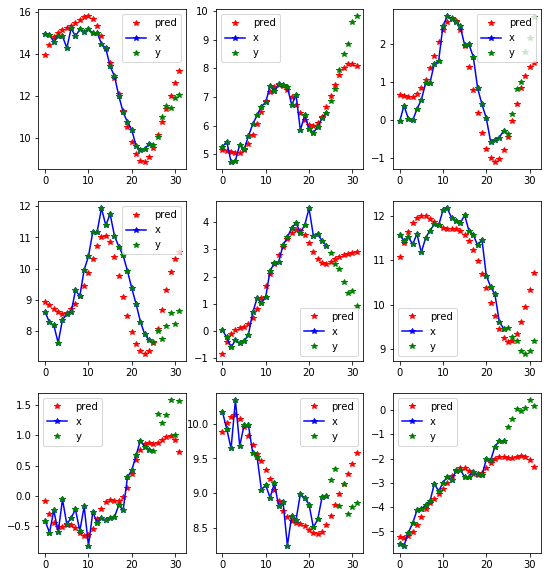

In [ ]:
learn.show_results(0)

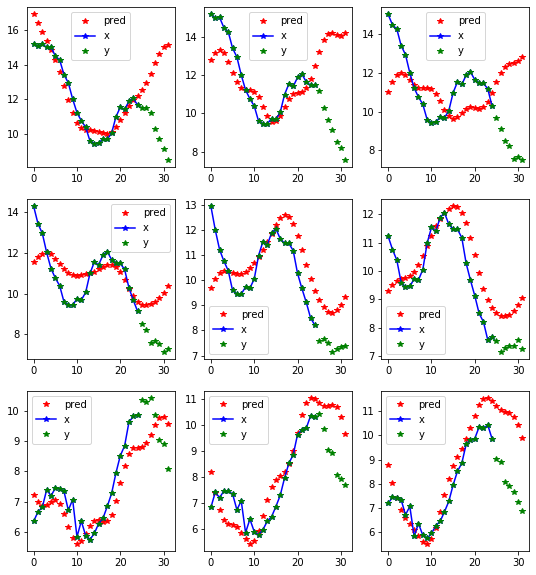

In [ ]:
learn.show_results(1)

## Another example

In [ ]:
df = pd.read_csv('/home/tako/dev/fastseq/data/airline-passengers.csv')
print(df.head())
items = L([np.array(list(df['Passengers'].values))])
items

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


(#1) [array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
       404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404,
       359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407,
       362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390,
       432])]

(1, 144)
Train:67; Valid: 19; Test 1


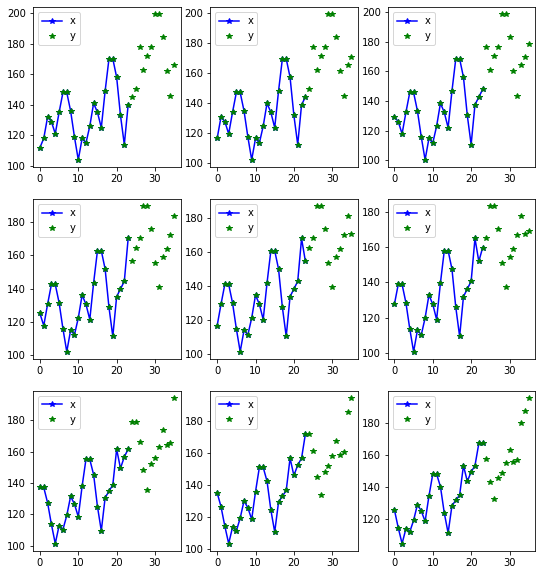

In [ ]:
horizon, lookback = 12,24
data = TSDataLoaders.from_items(items, lookback=lookback, horizon =horizon, step=1, bs=64)
data.show_batch()

epoch,train_loss,valid_loss,time
0,2.442768,2.071324,00:00
1,2.303048,0.994528,00:00
2,1.949394,0.842307,00:00
3,1.736230,0.854912,00:00
4,1.602172,0.841866,00:00
5,1.500812,0.751410,00:00
6,1.416816,0.690435,00:00
7,1.326123,0.624953,00:00
8,1.250510,0.599351,00:01
9,1.185108,0.587219,00:00


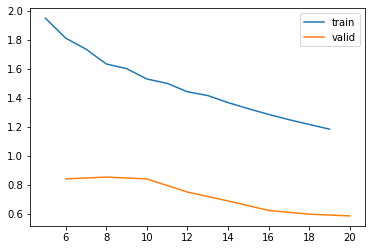

In [ ]:
mdl = NBeatsNet(device = data.train.device, stack_types=('trend','seasonality'), horizon=horizon, lookback=lookback, season = 24)
learn = Learner(data, mdl, loss_func=F.mse_loss, opt_func= Adam, )                             
                
learn.fit(10, .01)
learn.recorder.plot_loss()

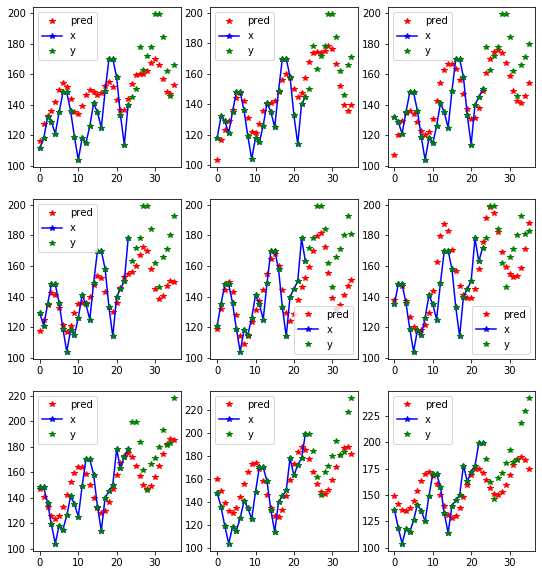

In [ ]:
learn.show_results(0)

In [ ]:
# hide
# Other Blocks
# not tested or tunned

In [ ]:

# class LinearD(nn.Linear):   
#     """"""
#     def forward(self, x, *args, **kwargs):
#         return super().forward(x)
        
# class GenericBlock(Block):
#     def __init__(
#         self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True,
#         bn_final=False, ps:L=None, share_thetas=True, y_range=[-.05,.05]
#     ):
#         store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
#         self.scale = torch.ones(self.thetas_dim,device=self.device)
#         super().__init__(LinearD(self.thetas_dim, self.horizon),LinearD(self.thetas_dim, self.lookback))        
#         self.to(device)
        

In [ ]:
# show_doc(LinearD, name='LinearD',title_level=4)

In [ ]:
# mdl = GenericBlock([256], thetas_dim=4, device=device, lookback=100, horizon=10)
# dct = mdl(torch.randn(64,100).to(device))
# test_eq(dct['b'].shape, (64,100))
# test_eq(dct['f'].shape, (64,10))

In [ ]:
# hide
from nbdev.export import *
notebook2script()